## Introduction

### Understanding the Label

*0 -> Sadness* <br/>
*1 -> Joy* <br/>
*2 -> Love* <br/>
*3 -> Anger* <br/>
*4 -> Fear* <br/>
*5 -> Surprise* <br/>

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from datasets import load_dataset


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.10.0


## Importing Dataset

In [3]:
dataset = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/mayank/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [6]:
# Fetching Training, Validation tweets and labels
train_tweets, train_labels = get_tweets(train)
val_tweets, val_label = get_tweets(val)

In [7]:
# Printing Training Data
print(train_tweets[0])
print(train_labels[0])

i didnt feel humiliated
0


In [8]:
# Printing Validation Data
print(val_tweets[0])
print(val_label[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
0


## Tokenizing

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_tweets)

In [11]:
# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

# print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

total words: 15214


## Padding and Truncating Sequences

### Converting training data

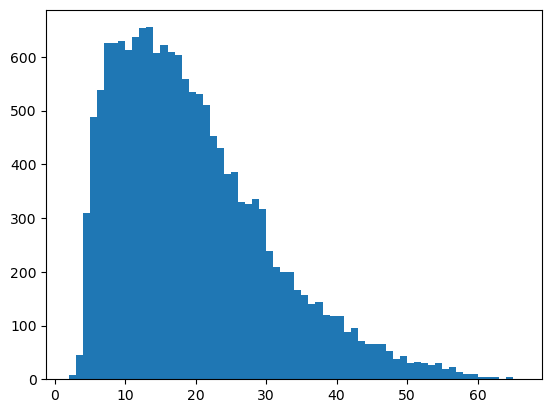

In [12]:
# Checking frequency of the length of tweets
lengths = [len(t.split(' ')) for t in train_tweets]
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the training tweets
training_sequences = tokenizer.texts_to_sequences(train_tweets)
# Get the maximum length of the tweet
max_sequence_len = max([len(x) for x in training_sequences])
# Padding all the tweets
training_padded = np.array(pad_sequences(training_sequences, maxlen=max_sequence_len, padding="post"))

# Tokenize the validation tweets
validating_sequences = tokenizer.texts_to_sequences(val_tweets)
# Padding the validation tweets
validating_padded = np.array(pad_sequences(validating_sequences, maxlen=max_sequence_len, padding="post"))

In [14]:
max_sequence_len

66

In [13]:
training_padded[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

### Training label

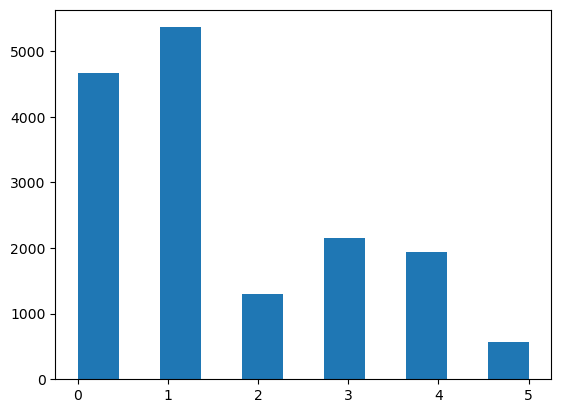

In [14]:
plt.hist(train_labels, bins=11)
plt.show()

In [15]:
training_labels = np.array(train_labels)
training_labels

array([0, 0, 3, ..., 1, 3, 0])

In [16]:
validating_labels = np.array(val_label)
validating_labels

array([0, 0, 2, ..., 1, 1, 1])

## Creating Model

In [17]:
max([len(x) for x in training_sequences])

66

In [18]:
import tensorflow as tf
vocab_size = 10000
embedding_dim = 16

# Model 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-04 15:44:22.772355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-04 15:44:22.772503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 66, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [19]:
NUM_EPOCHS = 10

# Train the model
history_model = model.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(validating_padded, validating_labels))

Epoch 1/10


2023-02-04 15:44:23.463955: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-04 15:44:24.836259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:44:25.158888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:44:25.177940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:44:25.399837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:44:25.415099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:44:25.663787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

500/500 [==============================] - ETA: 0s - loss: 1.3582 - accuracy: 0.4561

2023-02-04 15:45:04.880357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:45:05.023261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:45:05.034405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:45:05.234310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-04 15:45:05.246009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 45s 84ms/step - loss: 1.3582 - accuracy: 0.4561 - val_loss: 0.8651 - val_accuracy: 0.6960
Epoch 2/10
500/500 [==============================] - 40s 80ms/step - loss: 0.5918 - accuracy: 0.8051 - val_loss: 0.5736 - val_accuracy: 0.8210
Epoch 3/10
500/500 [==============================] - 41s 83ms/step - loss: 0.3365 - accuracy: 0.8892 - val_loss: 0.4195 - val_accuracy: 0.8615
Epoch 4/10
500/500 [==============================] - 42s 84ms/step - loss: 0.2110 - accuracy: 0.9381 - val_loss: 0.3689 - val_accuracy: 0.8900
Epoch 5/10
500/500 [==============================] - 40s 80ms/step - loss: 0.1434 - accuracy: 0.9572 - val_loss: 0.3603 - val_accuracy: 0.8935
Epoch 6/10
500/500 [==============================] - 40s 80ms/step - loss: 0.1354 - accuracy: 0.9574 - val_loss: 0.3784 - val_accuracy: 0.8920
Epoch 7/10
500/500 [==============================] - 40s 80ms/step - loss: 0.0983 - accuracy: 0.9696 - val_loss: 0.4143 - val_accuracy: 0.8930
Epo

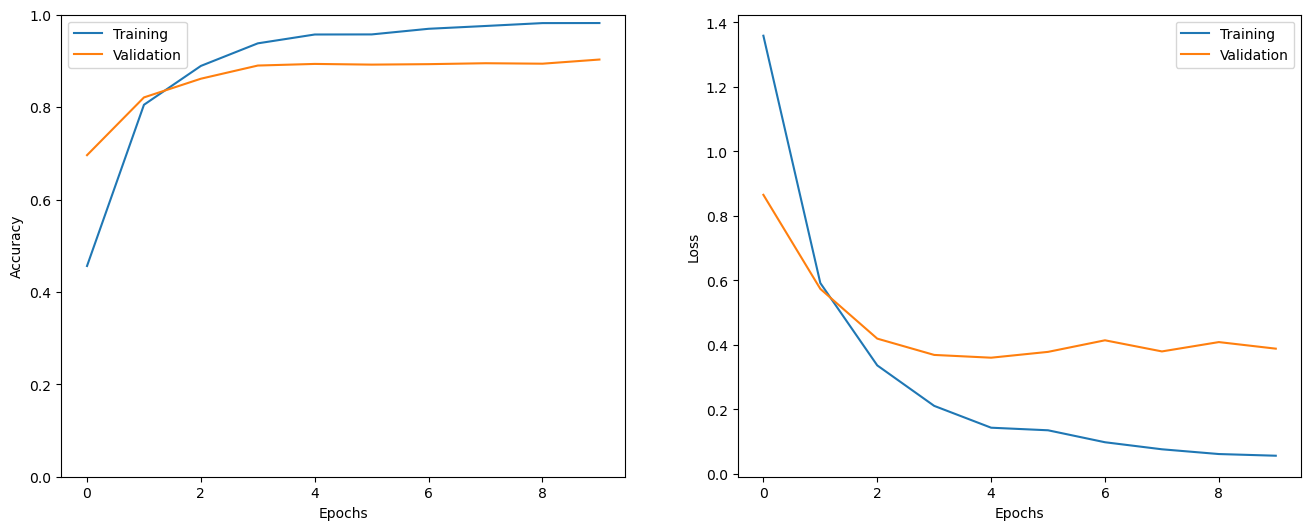

In [20]:
show_history(history_model)

## Testing the model with the Test Data

In [22]:
# Fetching tweets and labels of Test Data
test_tweets, test_labels = get_tweets(test)

In [31]:
test_tweets[3]

'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived'

In [32]:
test_labels[3]

1

In [36]:
testing_labels = np.array(test_labels)
testing_labels

array([0, 0, 0, ..., 1, 1, 4])

In [37]:
# Tokenize the validation tweets
testing_sequences = tokenizer.texts_to_sequences(test_tweets)
# Padding the validation tweets
testing_padded = np.array(pad_sequences(testing_sequences, maxlen=max_sequence_len, padding="post"))

In [38]:
testing_padded

array([[ 17,   8, 203, ...,   0,   0,   0],
       [ 17,   1,  11, ...,   0,   0,   0],
       [  2, 145,  80, ...,   0,   0,   0],
       ...,
       [  2,   3,   9, ...,   0,   0,   0],
       [ 17,   8,  38, ...,   0,   0,   0],
       [  2,   3,  36, ...,   0,   0,   0]], dtype=int32)

In [39]:
test_hist_model = model.evaluate(testing_padded, testing_labels)

63/63 [==============================] - 3s 42ms/step - loss: 0.3710 - accuracy: 0.8930


In [24]:
class_cat = {0 : 'Sadness', 1 : 'Joy', 2 : 'Love', 3 : 'Anger', 4 : 'Fear', 5 : 'Surprise'}
class_cat[0]

'Sadness'

In [65]:
i = random.randint(0, len(test_labels)-1)
print('Sentence: ', test_tweets[i])
print('Emotion: ', class_cat[test_labels[i]])

p = model.predict(np.expand_dims(testing_padded[i], axis=0))[0]
pred_class = class_cat[np.argmax(p).astype('uint8')]
print(np.argmax(p).astype('uint8'))
print(pred_class)

Sentence:  i feel i was so innocent to have only one dream to fill my brain and to be crazy about it
Emotion:  Joy
1/1 [==============================] - 0s 72ms/step
1
Joy


## Visualize Word Embeddings

In [69]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


In [70]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

## Saving the model & the tokenizer

In [76]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [71]:
model.save('model.h5')

In [27]:
i = random.randint(0, len(test_labels)-1)
print('Sentence: ', test_tweets[i])
print('Emotion: ', class_cat[test_labels[i]])

p = model.predict(np.expand_dims(testing_padded[i], axis=0))[0]
pred_class = class_cat[np.argmax(p).astype('uint8')]
print(np.argmax(p).astype('uint8'))
print(pred_class)

NameError: name 'test_labels' is not defined

In [83]:
i = random.randint(0, len(train_labels)-1)
print('Sentence: ', train_tweets[i])
print('Emotion: ', class_cat[train_labels[i]])

Sentence:  i miss how safe and comfortable he made me feel and how vulnerable i was able to be with him because i knew he loved me
Emotion:  Fear
